# Predicting most Efficient Interventions for Life Span Increase
#### Data Literacy at University of Tübingen, Winter 2023/24

---
&copy; Daniel Flat, Jackson Harmon, Eric Nazarenus, Aline Bittler 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

Template by Philipp Hennig, 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dataclasses import dataclass
from scipy.optimize import curve_fit

In [2]:
# Group Constants
MALE = 'male'
FEMALE = 'female'
SEX_CATEGORIES = [MALE, FEMALE]

# Intervention Constants
CONTROL_GROUP = 'None'
ALL_GROUP = 'All'
ONE_REMOVED_PREFIX = 'no_'

# Dataset Contsants
DATASET_DIRECTORY = os.path.join('..', 'dat', 'RMR_data')

# Graphing constants
COLOR_MAP = ["#ADD8E6", "#008000", "#FFD700", "#800080", "#FF7F50", "#40E0D0", "#708090", "#FF8C00", "#FF00FF", "#008080"]

### Parsing the data
In this section we take the extracted values of the robust mouse rejuvination study and wrangle the data into the format needed for modeling the data.

In [3]:
dataset_paths = os.listdir(DATASET_DIRECTORY)

def convert_filename_to_key(filename, category):
    category_removed = filename[len(category) + 1:]
    return os.path.splitext(category_removed)[0]

def create_dataset_mapping(dataset_directory, categories):
    dataset_mappings = {}
    
    for category in categories:
        category_path = {} 
        for path in dataset_paths:
            full_path = os.path.join(dataset_directory, path)
    
            if category == path[:len(category)]:
                key = convert_filename_to_key(path, category)
                category_path[key] = full_path
        dataset_mappings[category] = category_path
    
    return dataset_mappings

In [4]:
def is_one_removed_intervention(key):
    if len(key) < 3:
        return False

    return key[:len(ONE_REMOVED_PREFIX)] == ONE_REMOVED_PREFIX

def extract_single_interventions(dataset_mapping: dict):
    single_interventions = []
    for key in dataset_mapping.keys():
        if key == ALL_GROUP:
            continue
        elif key == CONTROL_GROUP:
            continue
        elif is_one_removed_intervention(key):
            continue
        else:
            single_interventions.append(key)
    
    return single_interventions

def create_one_removed_key(key: str, intervention_list: []) -> []:
    removed_key = key[len(ONE_REMOVED_PREFIX):]

    removed_intervention_list = []
    for intervention in intervention_list:
        if intervention != removed_key:
            removed_intervention_list.append(intervention)

    return removed_intervention_list

def create_intervention_list_from_group(key: str, intervention_list: []):
    new_intervention_list = None
    
    if key == ALL_GROUP:
        new_intervention_list = intervention_list
    elif key == CONTROL_GROUP:
        new_intervention_list = []
    elif is_one_removed_intervention(key):
        new_intervention_list = create_one_removed_key(key, intervention_list)
    else:
        new_intervention_list = [key]

    return ','.join(new_intervention_list)

In [5]:
def load_csv(path):
    return pd.read_csv(
                        path,
                        skiprows=0,
                        sep=',',
                        engine='python',
                        decimal='.',
                        dtype={'x': 'float64', 'y': 'float64'}
            )


def create_dataset_by_category(category_path: dict, single_interventions: []):
    datasets = {}
    for key, path in category_path.items():
        new_key = create_intervention_list_from_group(key, single_interventions)
        datasets[new_key] = load_csv(path)
    return datasets

dataset_mapping = create_dataset_mapping(DATASET_DIRECTORY, SEX_CATEGORIES)
female_dataset_paths = dataset_mapping[FEMALE]
female_single_interventions = extract_single_interventions(female_dataset_paths)

female_dataset = create_dataset_by_category(female_dataset_paths, female_single_interventions)

### Modeling
It should be noted that from the study we have data on the following:
- No interventions
- Single Interventions
- Three Interventions
- Four (All) Interventions

Because of this we can simply fit the Gompertz curve to each of these for those resp. models. However in order to fufill the objective of finding the combination of interventions most likely to increase the lifespan of mice we still need to consider one case, that is, the case of two interventions. In order to do this in the following sections we come of with models with how interventions relate to one-another and then test how these assumptions hold on the data we have. For example, we might make an assumption on how the interventions interact with each other using only single and three intervention data. We can then validate this assumption by measuring how it performs on the all interventions. If it holds well, then we apply the same assumption to the two interventions.

After modeling the two interventions, and with regard to the assumptions, we can use the model of each case and simply take the best performing curve as our prediction of the best subset of interventions.

In [6]:
def gompertz(x, alpha, beta):
    return alpha * np.exp(beta * x)

@dataclass
class GompertzParameters:
    alpha: np.float64
    beta: np.float64

    @staticmethod
    def from_sequence(seq):
        return GompertzParameters(alpha=seq[0], beta=seq[1])

    def to_tuple(self):
        return (self.alpha, self.beta)

    def __str__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'

    def __repr__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'


DEFAULT_INITIAL_PARAMETERS = GompertzParameters(alpha=0.1, beta=0.085)

def fit_gompertz_model(ages: pd.DataFrame,
                       mortality_rate: pd.DataFrame,
                       initial_parameters: GompertzParameters = DEFAULT_INITIAL_PARAMETERS,
                       max_fit_iterations: int = 2_500) -> GompertzParameters:
    p0 = initial_parameters.to_tuple()
    predicted_parameters, covariance = curve_fit(gompertz, ages, mortality_rate, p0=p0, maxfev=max_fit_iterations)
    return GompertzParameters.from_sequence(predicted_parameters)

test_dataset = female_dataset['HSCs']

def calculate_ages(dataset):
    return np.array(dataset.x) / 365 # ages in years

def calculate_mortality_rate(dataset):
    return np.array(1 - dataset.y)

def fit(dataset):
    ages = calculate_ages(dataset)
    mortality_rate = calculate_mortality_rate(dataset)
    
    predicted_parameters = fit_gompertz_model(ages, mortality_rate)
    predicted_mortality = gompertz(ages, predicted_parameters.alpha, predicted_parameters.beta)
    return predicted_mortality

In [7]:
def plot_fitted_gompertz_curve(ages, mortality_rate, all_mortality_rate, single_mortality_rate, title: str) -> None:
    plt.scatter(ages, mortality_rate, label='Observed Data', color=COLOR_MAP[0])
    plt.plot(ages, predicted_mortality, label='All Gompertz Fit', color=COLOR_MAP[1])
    plt.plot(ages, single_mortality_rate, label='Single Gompertz Fit', color=COLOR_MAP[2])
    plt.xlabel('Age of Mice (Years)')
    plt.ylabel(f'Mortality Rate ({title})')
    plt.legend()
    plt.show()

In [8]:
tests = [
    ['Gal-Nav,mTERT,Rapamycin', ['Gal-Nav', 'mTERT', 'Rapamycin']],
    ['HSCs,Gal-Nav,Rapamycin', ['HSCs', 'Gal-Nav', 'Rapamycin']],
    ['HSCs,mTERT,Rapamycin', ['HSCs', 'mTERT', 'Rapamycin']],
    ['HSCs,Gal-Nav,mTERT', ['HSCs', 'Gal-Nav', 'mTERT']]
]

### Additive Model (wrt output)
We begin with one of the most simple tests possible. We make the assumption that single interventions are additive. That is, the mortality curve of three interventions should be the same as the individual mortality curves of the three interventions added together. We can clearly see below that this is not the case. Namely, the adding of the single models overestimates the mortality curve every time.

After further thinking this is clear for two reasons. The first is that the mortality rate as time goes to infinity should reach one, however with adding the curves it will approach 3 instead, which does not make sense. Secondly, it is perfectly possible that multiple interventions could either influence each other negatively or target the same mechanism, thereby explaining the sub-linear properties we see.

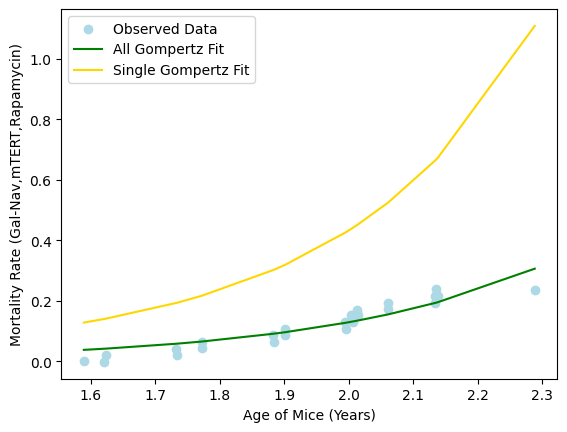

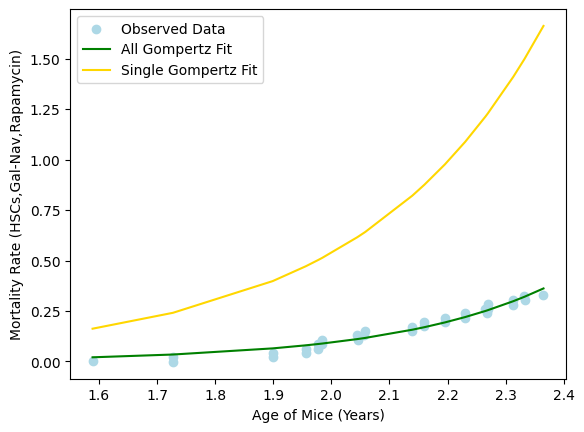

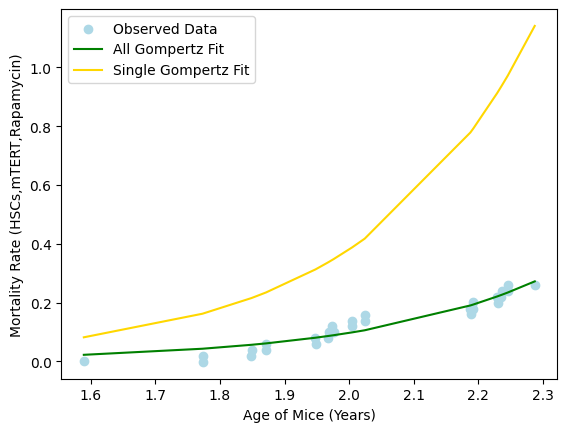

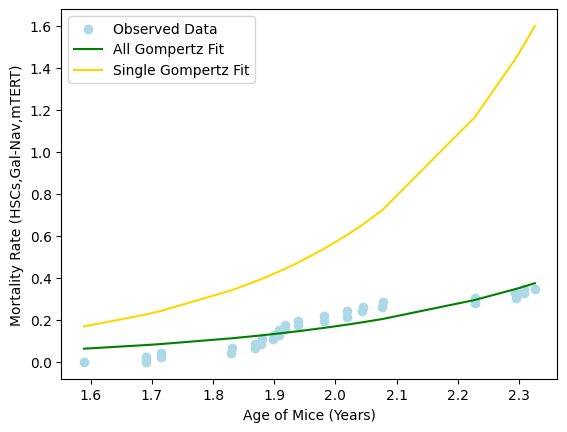

In [9]:
for keys in tests:
    all_key, single_keys = keys

    all_ages = calculate_ages(female_dataset[all_key])
    all_mortality_rate = calculate_mortality_rate(female_dataset[all_key])
    
    predicted_parameters = fit_gompertz_model(all_ages, all_mortality_rate)
    predicted_mortality = gompertz(all_ages, predicted_parameters.alpha, predicted_parameters.beta)

    single_predicted_mortality = 0
    for key in single_keys:
        single_ages = calculate_ages(female_dataset[key])
        single_mortality_rate = calculate_mortality_rate(female_dataset[key])
        
        predicted_parameters = fit_gompertz_model(single_ages, single_mortality_rate)
        single_predicted_mortality += gompertz(all_ages, predicted_parameters.alpha, predicted_parameters.beta)

    plot_fitted_gompertz_curve(all_ages, all_mortality_rate, predicted_mortality, single_predicted_mortality, all_key)

### Harmonic Mean of Beta Values

As the beta value represents a rate for this model we consider that the beta value of 3 interventions will be the harmonic mean of the 3 individual intervention beta values and likewise for 2. To test this we fit the alpha and beta values for the individual interventions and then the multiple interventions and compare the latter to the predicted beta values. For the alpha values we simply use the mean, but have also tried using the harmonic mean. In either case, we find that the values are overestimated.

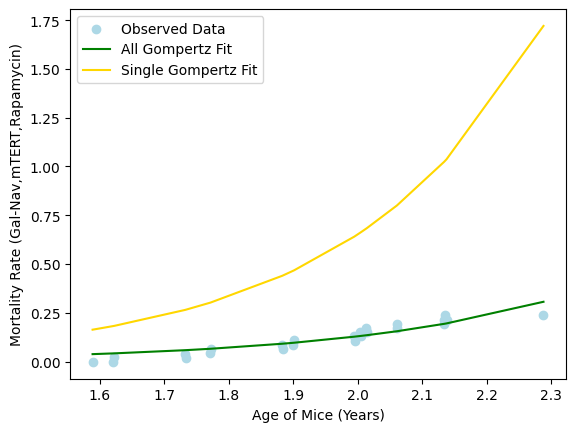

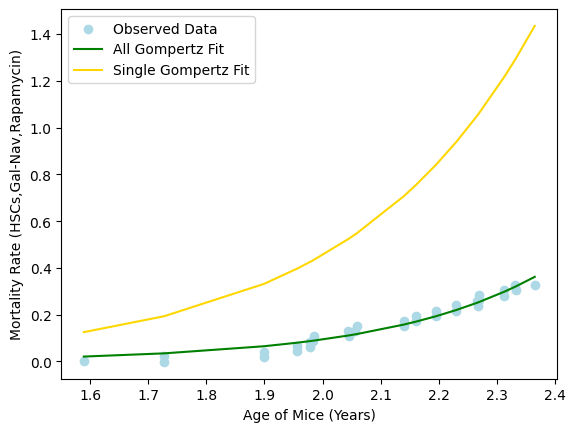

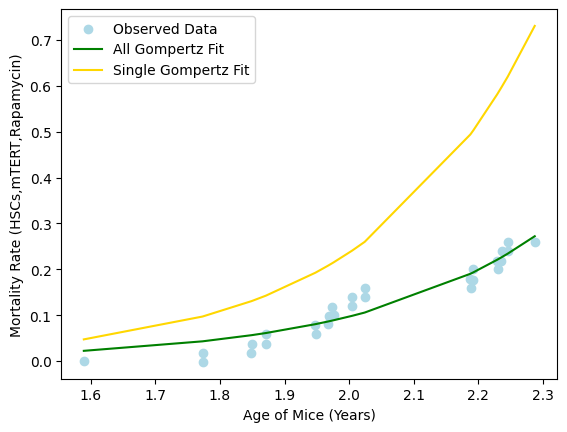

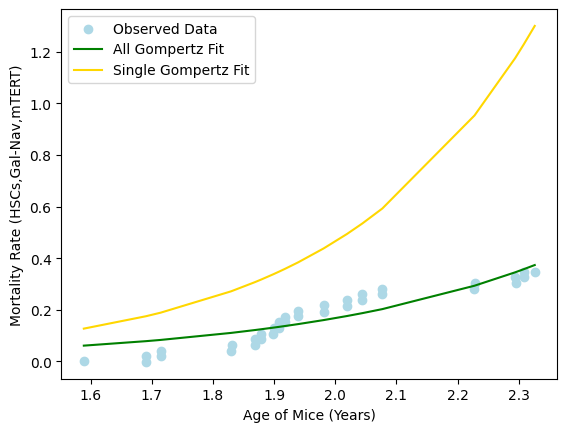

In [10]:
def harmonic_mean(values):
    denominator = []
    for value in values:
        denominator.append(1 / value)
    return len(values) / sum(denominator)

for keys in tests:
    all_key, single_keys = keys

    all_ages = calculate_ages(female_dataset[all_key])
    all_mortality_rate = calculate_mortality_rate(female_dataset[all_key])
    
    predicted_parameters = fit_gompertz_model(all_ages, all_mortality_rate)
    predicted_mortality = gompertz(all_ages, predicted_parameters.alpha, predicted_parameters.beta)
    
    alphas = []
    betas = []
    for key in single_keys:
        single_ages = calculate_ages(female_dataset[key])
        single_mortality_rate = calculate_mortality_rate(female_dataset[key])
        
        predicted_parameters = fit_gompertz_model(single_ages, single_mortality_rate)
        alphas.append(predicted_parameters.alpha)
        betas.append(predicted_parameters.beta)

    alpha = sum(alphas) / len(alphas)
    beta = harmonic_mean(betas)
    single_predicted_mortality = gompertz(all_ages, alpha, beta)
    plot_fitted_gompertz_curve(all_ages, all_mortality_rate, predicted_mortality, single_predicted_mortality, all_key)

### Linear Parameters Model with Parameter Smoothing
For our second test we try a linear model of the parameters and find that in this case the model also overestimates the survival rate. We do this by fitting the parameters of the single interventions, leave one out, and all interventions. We then use the single intervention parameters and use scalars to fit it to the leave one out interventions. Finally we measure how well it fits against the all interventions, finding it over estimates.

Note that we also apply what we refer to as parameter smoothing to mitigate against over-estimation. This refers to the fact that we multiply by a factor to adjust for the number of parameters.

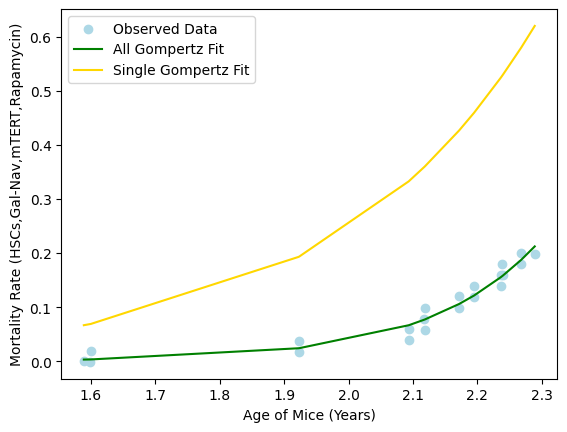

In [11]:
# Step 1: Fit parameters
alpha_parameters = {}
beta_parameters = {}
for key, current_dataset in female_dataset.items():
    all_ages = calculate_ages(current_dataset)
    all_mortality_rate = calculate_mortality_rate(current_dataset)
    
    predicted_parameters = fit_gompertz_model(all_ages, all_mortality_rate)
    
    alpha_parameters[key] = predicted_parameters.alpha
    beta_parameters[key] = predicted_parameters.beta


input_keys = [
    'HSCs',
    'Gal-Nav',
    'mTERT',
    'Rapamycin'
]

output_keys = [
    'HSCs,Gal-Nav,mTERT',
    'HSCs,Gal-Nav,Rapamycin',
    'HSCs,mTERT,Rapamycin',
    'Gal-Nav,mTERT,Rapamycin',
]

# Step 2: Create linear equation
input_alpha = np.array([alpha_parameters[key] for key in input_keys])
output_alpha = np.array([alpha_parameters[key] for key in output_keys])

input_beta = np.array([beta_parameters[key] for key in input_keys])
output_beta = np.array([beta_parameters[key] for key in output_keys])

matrix = np.array([
    [1, 1, 1, 0],
    [1, 1, 0, 1],
    [1, 0, 1, 1],
    [0, 1, 1, 1],
])

alpha_matrix = matrix * input_alpha
beta_matrix = matrix * input_beta


# Step 5: Solve Equation
new_alpha_lambda = np.linalg.pinv(alpha_matrix) @ output_alpha
new_beta_lambda = np.linalg.pinv(beta_matrix) @ output_beta

all_alpha_matrix = alpha_matrix[0].copy()
all_alpha_matrix[3] = alpha_matrix[1][3]

all_beta_matrix = beta_matrix[0].copy()
all_beta_matrix[3] = beta_matrix[1][3]

adjustment_factor = 3 / 4 # smooths out the alpha and beta values according to their apperance

new_alpha = all_alpha_matrix @ new_alpha_lambda * adjustment_factor
new_beta = all_beta_matrix @ new_beta_lambda * adjustment_factor

key = 'HSCs,Gal-Nav,mTERT,Rapamycin'

all_ages = calculate_ages(female_dataset[key])
all_mortality_rate = calculate_mortality_rate(female_dataset[key])

predicted_parameters = fit_gompertz_model(all_ages, all_mortality_rate)
predicted_mortality = gompertz(all_ages, predicted_parameters.alpha, predicted_parameters.beta)

single_predicted_mortality = gompertz(all_ages, new_alpha, new_beta)

plot_fitted_gompertz_curve(all_ages, all_mortality_rate, predicted_mortality, single_predicted_mortality, key)

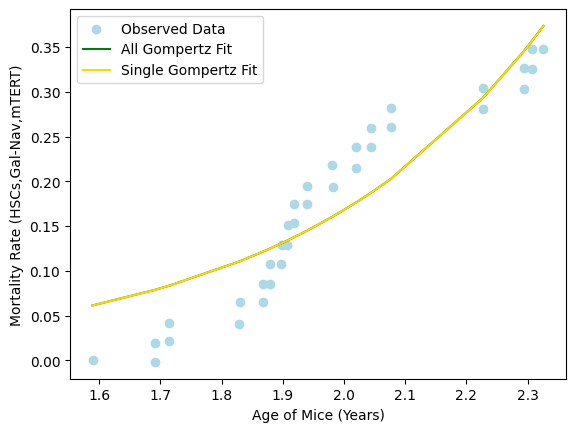

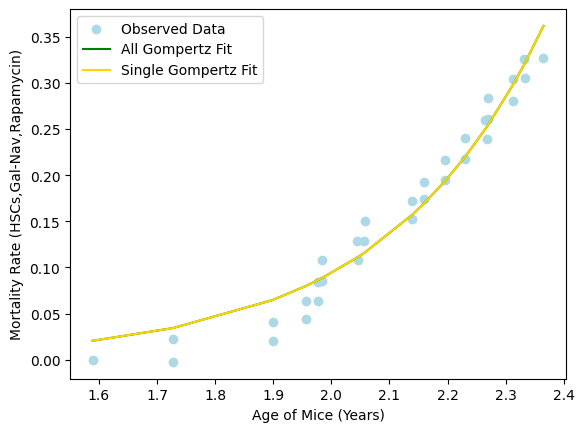

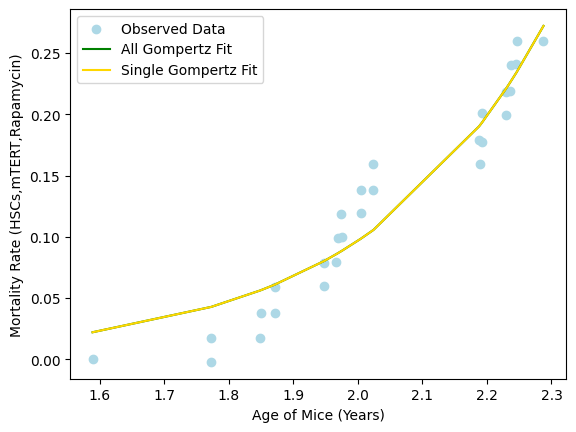

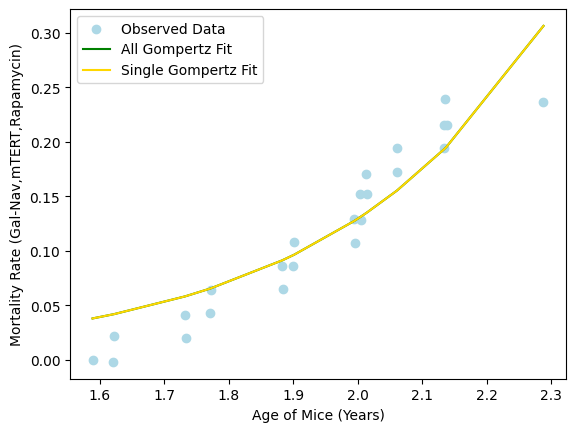

In [12]:
# Ensure that the single intervention curves match exactly as a sanity check

new_alpha = alpha_matrix @ new_alpha_lambda
new_beta = beta_matrix @ new_beta_lambda

for i in range(len(output_keys)):
    key = output_keys[i]

    all_ages = calculate_ages(female_dataset[key])
    all_mortality_rate = calculate_mortality_rate(female_dataset[key])

    predicted_parameters = fit_gompertz_model(all_ages, all_mortality_rate)
    predicted_mortality = gompertz(all_ages, predicted_parameters.alpha, predicted_parameters.beta)
    
    single_predicted_mortality = gompertz(all_ages, new_alpha[i], new_beta[i])
    
    plot_fitted_gompertz_curve(all_ages, all_mortality_rate, predicted_mortality, single_predicted_mortality, key)

### Second-Order Model
Notation: m_i, m_ij and m_ijk are the predicted mortality rate when using interventions i; i and j; and i, j, and k resp. i_jk and i_jkl are the interaction factors of how "non-linear" the mortality rate is. That is,
i_jk = m_jk - (m_j + m_k)
i_jkl = m_jkl - (m_j + m_k + m_l)

Therefore we can come up with the following equations (1):

m_123 = m_1 + m_2 + m_3 + i_123

m_124 = m_1 + m_2 + m_4 + i_124

m_234 = m_2 + m_3 + m_4 + i_234

m_1234 = m_1 + m_2 + m_3 + m_4 + i_1234

We can make further assumptions that interactions are pairwise additive. That is,
i_123 = i_12 + i_13 + i_23

This leads us to the following equations (2):

i_123 = i_12 + i_13 + i_23

i_124 = i_12 + i_14 + i_24

i_234 = i_23 + i_24 + i_34

i_1234 = i_12 + i_13 + i_14 + i_23 + i_24 + i_34

We already know the values of the m's, but just not the i's. While equations (1) are 4 equations of 4 unknowns, meaning we can solve for the i's, unfortunately equations (2) is 4 equations of 6 unknowns therefore has multiple solutions. We use the pseudo inverse to solve it for one particular solution.

In [13]:
# Step 1: Fit parameters
alpha_parameters = {}
beta_parameters = {}
for key, current_dataset in female_dataset.items():
    all_ages = calculate_ages(current_dataset)
    all_mortality_rate = calculate_mortality_rate(current_dataset)
    
    predicted_parameters = fit_gompertz_model(all_ages, all_mortality_rate)
    
    alpha_parameters[key] = predicted_parameters.alpha
    beta_parameters[key] = predicted_parameters.beta


single_keys = [
    'HSCs',
    'Gal-Nav',
    'mTERT',
    'Rapamycin'
]

two_keys = [
    'HSCs,Gal-Nav',
    'HSCs,mTERT',
    'HSCs,Rapamycin',
    'Gal-Nav,mTERT',
    'Gal-Nav,Rapamycin',
    'mTERT,Rapamycin'
]

multiple_keys = [
    'HSCs,Gal-Nav,mTERT',
    'HSCs,Gal-Nav,Rapamycin',
    'HSCs,mTERT,Rapamycin',
    'Gal-Nav,mTERT,Rapamycin',
]

# Step 2: Create linear equation
single_alpha = np.array([alpha_parameters[key] for key in single_keys])
single_beta = np.array([beta_parameters[key] for key in single_keys])

multiple_alpha = np.array([alpha_parameters[key] for key in multiple_keys])
multiple_beta = np.array([beta_parameters[key] for key in multiple_keys])

multiple_indices = [[0, 1, 2],
                    [0, 1, 3],
                    [0, 2, 3],
                    [1, 2, 3]]

ages = calculate_ages(female_dataset[key])
mortality_rate = calculate_mortality_rate(female_dataset[key])

single_mortality = []
for i in range(len(single_alpha)):
    single_mortality.append(gompertz(ages, single_alpha[i], single_beta[i]))

multiple_mortality = []
for i in range(len(multiple_alpha)):
    multiple_mortality.append(gompertz(ages, multiple_alpha[i], multiple_beta[i]))

diffs = []
for i in range(len(multiple_indices)):
    diff = multiple_mortality[i].copy()
    for index in multiple_indices[i]:
        diff -= single_mortality[index]
    diffs.append(diff)

# Interactions between i and j is listed as ij
#            12 13 14 23 24 34
matrix = np.array([
            [1, 1, 0, 1, 0, 0],
            [1, 0, 1, 0, 1, 0],
            [1, 0, 0, 0, 1, 1],
            [1, 1, 1, 1, 1, 1]
])

inv_matrix = np.linalg.pinv(matrix)

interaction_factors = []
for time_step in range(len(diff)):
    current_time_step_diff = np.array(list([diff[time_step] for diff in diffs]))
    time_step_interaction_factors = inv_matrix @ current_time_step_diff
    interaction_factors.append(time_step_interaction_factors)

In [14]:
slopes = {}

### Predict No Interventions

In [15]:
EPS = 1e-7
NO_INTERVENTION_KEY = ''

# Compute prediction
no_intervention_ages = calculate_ages(female_dataset[NO_INTERVENTION_KEY])
no_intervention_mortality_rate = calculate_mortality_rate(female_dataset[NO_INTERVENTION_KEY])
no_intervention_log_mortality_rate = np.log(no_intervention_mortality_rate + EPS)

predicted_parameters = fit_gompertz_model(no_intervention_ages, no_intervention_mortality_rate)
predicted_mortality = gompertz(all_ages, predicted_parameters.alpha, predicted_parameters.beta)
log_predicted_mortality = np.log(predicted_mortality + EPS)

# Compute slope
numerator = log_predicted_mortality[-1] - log_predicted_mortality[0]
denominator = all_ages[-1] - all_ages[0]
slope = numerator / denominator
slopes['No Interventions'] = slope
slopes

/tmp/ipykernel_12563/1260709209.py:7: RuntimeWarning: invalid value encountered in log
  no_intervention_log_mortality_rate = np.log(no_intervention_mortality_rate + EPS)


{'No Interventions': 2.5761940770774046}

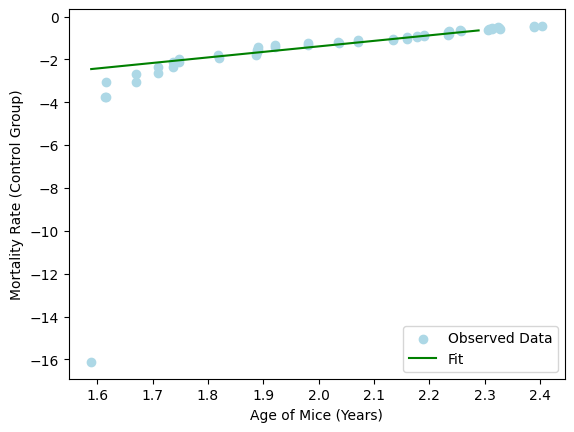

In [16]:
# Plot
plt.scatter(no_intervention_ages, no_intervention_log_mortality_rate, label='Observed Data', color=COLOR_MAP[0])
plt.plot(all_ages, log_predicted_mortality, label='Fit', color=COLOR_MAP[1])
plt.xlabel('Age of Mice (Years)')
plt.ylabel(f'Mortality Rate (Control Group)')
plt.legend()
plt.show()

### Predict Single Interventions

/tmp/ipykernel_12563/4067020357.py:15: RuntimeWarning: invalid value encountered in log
  actual_log_mortality_rate = np.log(calculate_mortality_rate(current_dataset) + EPS)


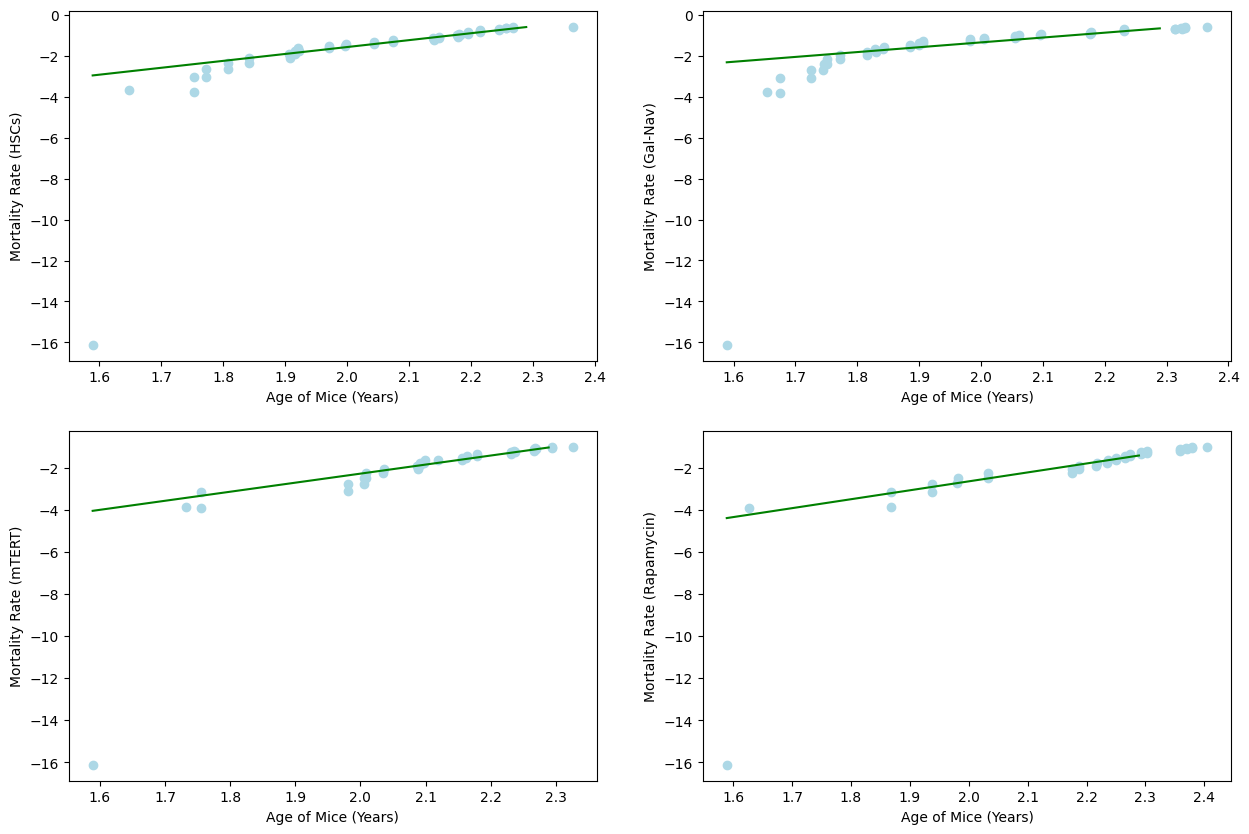

In [17]:
EPS = 1e-7

n_cols = 2
n_rows = 2
fig, axis = plt.subplots(n_cols, n_rows, figsize=(15, 10))

for i in range(len(single_mortality) // n_cols):
    for j in range(n_cols):
        intervention_index = n_cols * i + j

        # Get the acutal data points
        intervention_key = single_keys[intervention_index]
        current_dataset = female_dataset[intervention_key]
        current_ages = calculate_ages(current_dataset)
        actual_log_mortality_rate = np.log(calculate_mortality_rate(current_dataset) + EPS)

        # Use predicted mortality rate
        single_log_mortality_rate = np.log(single_mortality[intervention_index] + EPS)

        # Compute slopes
        numerator = single_log_mortality_rate[-1] - single_log_mortality_rate[0]
        denominator = all_ages[-1] - all_ages[0]
        slope = numerator / (denominator + EPS)
        slopes[intervention_key] = slope

        # Plot
        axis[i][j].scatter(current_ages, actual_log_mortality_rate, label='Observed Data', color=COLOR_MAP[0])
        axis[i][j].plot(all_ages, single_log_mortality_rate, label='All Gompertz Fit', color=COLOR_MAP[1])
            
        axis[i][j].set_xlabel('Age of Mice (Years)')
        axis[i][j].set_ylabel(f'Mortality Rate ({intervention_key})')

plt.show()

In [18]:
slopes

{'No Interventions': 2.5761940770774046,
 'HSCs': 3.3751854686637093,
 'Gal-Nav': 2.366404675485466,
 'mTERT': 4.300509354643063,
 'Rapamycin': 4.2474202017082945}

### Predict All Interventions

In [19]:
EPS = 1e-7

def calculate_two_intervention_log_mortality_rates(single_mortality, interaction_factors):
    sum_interactions = [sum(interaction_factor) for interaction_factor in interaction_factors]
    mortality_rate = sum(single_mortality) + np.array(sum_interactions)
    return np.log(mortality_rate + EPS)

all_log_mortality_rate = calculate_two_intervention_log_mortality_rates(single_mortality, interaction_factors)

ALL_KEY = 'HSCs,Gal-Nav,mTERT,Rapamycin'
actual_all_prediction = np.log(gompertz(all_ages, alpha_parameters[ALL_KEY], beta_parameters[ALL_KEY]))

# Compute the slope
numerator = all_log_mortality_rate[-1] - all_log_mortality_rate[0]
denominator = all_ages[-1] - all_ages[0]
slope = numerator / (denominator + EPS)
slopes[ALL_KEY] = slope
slopes

{'No Interventions': 2.5761940770774046,
 'HSCs': 3.3751854686637093,
 'Gal-Nav': 2.366404675485466,
 'mTERT': 4.300509354643063,
 'Rapamycin': 4.2474202017082945,
 'HSCs,Gal-Nav,mTERT,Rapamycin': 3.2259308296933464}

/tmp/ipykernel_12563/925433227.py:1: RuntimeWarning: divide by zero encountered in log
  log_mortality_rate = np.log(mortality_rate)
/tmp/ipykernel_12563/925433227.py:1: RuntimeWarning: invalid value encountered in log
  log_mortality_rate = np.log(mortality_rate)


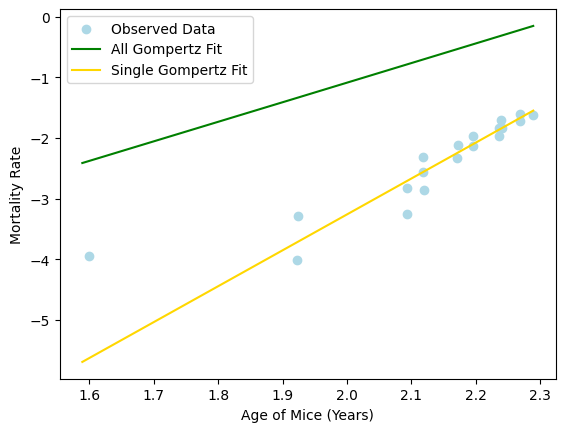

In [20]:
log_mortality_rate = np.log(mortality_rate)

plt.scatter(all_ages, log_mortality_rate, label='Observed Data', color=COLOR_MAP[0])
plt.plot(all_ages, all_log_mortality_rate, label='All Gompertz Fit', color=COLOR_MAP[1])
plt.plot(all_ages, actual_all_prediction, label='Single Gompertz Fit', color=COLOR_MAP[2])
plt.xlabel('Age of Mice (Years)')
plt.ylabel(f'Mortality Rate')
plt.legend()
plt.show()

In [21]:
N_INTERVENTIONS = 4

def calculate_two_intervention_log_mortality_rates(interaction_factors, n_interventions):
    log_mortality_rates = []

    interaction_factor_index = 0
    for i in range(N_INTERVENTIONS):
        for j in range(i + 1, N_INTERVENTIONS):
            interaction_factor = np.array([factor[interaction_factor_index] for factor in interaction_factors])
            
            two_intervention_mortality_rate = single_mortality[i] + single_mortality[j] + interaction_factor
            log_mortality_rate = np.log(two_intervention_mortality_rate + 1e-7)

            log_mortality_rates.append(log_mortality_rate)
            
            interaction_factor_index += 1
    
    return log_mortality_rates


log_mortality_rates = calculate_two_intervention_log_mortality_rates(interaction_factors, N_INTERVENTIONS)

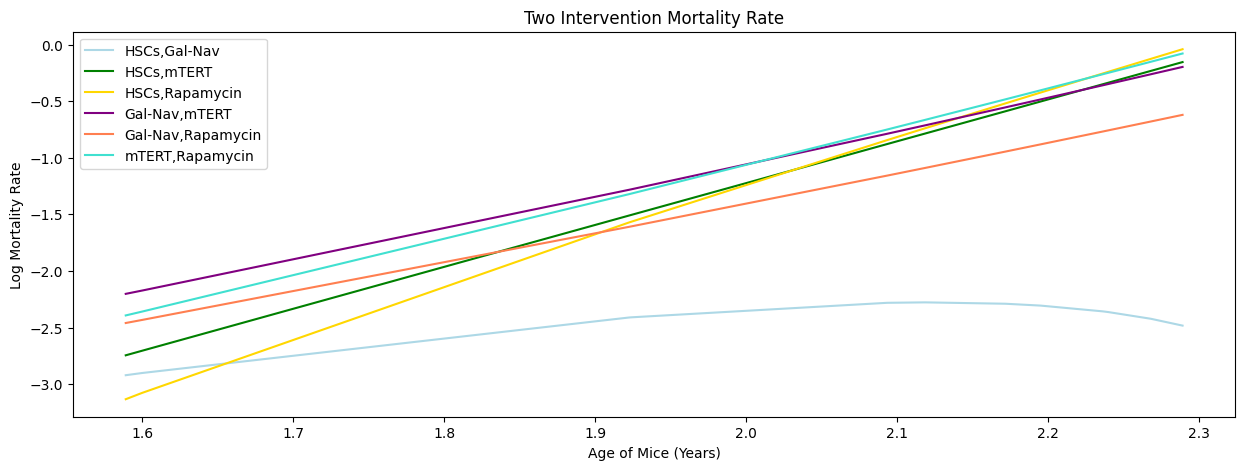

In [22]:
def create_two_intervention_title(keys, i, j):
    return f'{keys[i]},{keys[j]}'

def plot_two_intervention_curve(x, y, title, index):
    color = COLOR_MAP[index]
    plt.plot(x, y, label=title, color=color)

def plot_log_mortality_rates(all_ages, log_mortality_rates, single_keys, n_interventions):
    fig = plt.figure(figsize=(15, 5))

    interaction_factor_index = 0
    for i in range(N_INTERVENTIONS):
        for j in range(i + 1, N_INTERVENTIONS):
            title = create_two_intervention_title(single_keys, i, j)
            log_mortality_rate = log_mortality_rates[interaction_factor_index]
            plot_two_intervention_curve(all_ages, log_mortality_rate, title, interaction_factor_index)
            interaction_factor_index += 1

    plt.title('Two Intervention Mortality Rate')
    plt.xlabel('Age of Mice (Years)')
    plt.ylabel(f'Log Mortality Rate')
    plt.legend()
    plt.show()

plot_log_mortality_rates(all_ages, log_mortality_rates, single_keys, N_INTERVENTIONS)

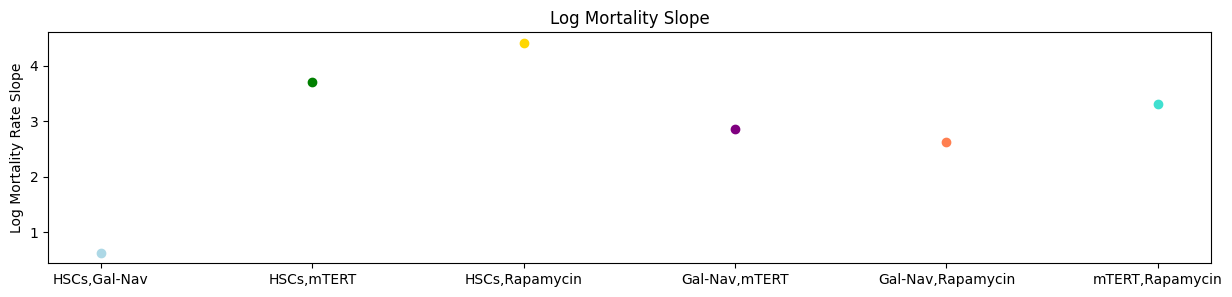

In [23]:
EPS = 1e-7
fig = plt.figure(figsize=(15, 3))

interaction_factor_index = 0

for i in range(N_INTERVENTIONS):
    for j in range(i + 1, N_INTERVENTIONS):
        # Compute log mortality slope
        log_mortality_rate = log_mortality_rates[interaction_factor_index]
        numerator = log_mortality_rate[-1] - log_mortality_rate[0]
        denominator = all_ages[-1] - all_ages[0]
        slope = numerator / (denominator + EPS)

        intervention_key = two_keys[interaction_factor_index]
        slopes[intervention_key] = slope

        # Graph Log Mortality
        color = COLOR_MAP[interaction_factor_index]
        title = f'{single_keys[i]},{single_keys[j]}'
        plt.scatter(title, slope, color=color)

        # Update
        interaction_factor_index += 1


plt.ylabel(f'Log Mortality Rate Slope')
plt.title('Log Mortality Slope')
plt.show()

In [24]:
slopes

{'No Interventions': 2.5761940770774046,
 'HSCs': 3.3751854686637093,
 'Gal-Nav': 2.366404675485466,
 'mTERT': 4.300509354643063,
 'Rapamycin': 4.2474202017082945,
 'HSCs,Gal-Nav,mTERT,Rapamycin': 3.2259308296933464,
 'HSCs,Gal-Nav': 0.6258053120972963,
 'HSCs,mTERT': 3.6995186179545922,
 'HSCs,Rapamycin': 4.415931938938512,
 'Gal-Nav,mTERT': 2.863124513019176,
 'Gal-Nav,Rapamycin': 2.6261911105055025,
 'mTERT,Rapamycin': 3.3048376303479374}

In [25]:
best_intervention = None
best_slope = None
for intervention, slope in slopes.items():
    if best_slope is None or best_slope > slope:
        best_intervention = intervention
        best_slope = slope

print(f'The intervention with the best predicted increase in lifespan is "{best_intervention}".')

The intervention with the best predicted increase in lifespan is "HSCs,Gal-Nav".
